# 1 Import, Path, Callback

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import os


from pathlib import Path
import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
path_data = Path('./data/')

path_models = Path('./models/')
path_backup = Path('./models/BackupAndRestore/')
path_chekpoint = Path('./models/Checkpoint/')

path_mlflow = Path('./mlruns/')
path_tblogs = Path('./tblogs/')
path_img = Path('./img/')


paths = [path_data, path_models, path_backup, path_chekpoint, path_mlflow, path_tblogs, path_img]

for path in paths:
    if os.path.exists(path):
        print(f"Folder {path} exists!")
    else:
        os.makedirs(path)
        print(f"Folder {path} was created.")

Folder data was created.
Folder models was created.
Folder models/BackupAndRestore was created.
Folder models/Checkpoint was created.
Folder mlruns was created.
Folder tblogs was created.
Folder img was created.


In [3]:
path_train_folder = Path('../input/cat-and-dog/training_set/training_set/')
path_test_folder = Path('../input/cat-and-dog/test_set/test_set/')
cats = 'cats'
dogs = 'cats'

train_cats = str(path_train_folder / cats)
train_dogs = str(path_train_folder / dogs)


num_cats_tr = len(glob.glob(pathname=train_cats + '/*.*'))
num_dogs_tr = len(glob.glob(pathname=train_dogs + '/*.*'))


print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

total training cat images: 4000
total training dog images: 4000


In [4]:
current_date = (datetime.now() + timedelta(hours=3)).strftime("%Y-%m-%d_%H-%M-%S")
path_logs = str(Path(path_tblogs / current_date))

callback_tboard = tf.keras.callbacks.TensorBoard(log_dir = path_logs, 
                                                 histogram_freq = 1,
                                                )
                                        
# Остановить обучение автоматически, как метрика перестянет меняться
callback_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      mode='min',
                                                      patience=3)

# Можно прерывать обучение и после восстанавливать его, callback смотрит в указанную папку
backup = tf.keras.callbacks.experimental.BackupAndRestore(path_backup)
# callback_backup = tf.keras.callbacks.BackupAndRestore(path_backup)

# Сохранение лучших результатов обучения
path_ch = Path(path_chekpoint / current_date)
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_ch,
                                                         save_weights_only=False, 
                                                         monitor='loss',
                                                         mode='min',
                                                         save_best_only=True)

2022-08-14 14:02:59.744560: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-14 14:02:59.745090: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-14 14:02:59.806564: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-08-14 14:02:59.840644: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-14 14:02:59.840805: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


# 2 Препроцессинг

In [5]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

In [6]:
BATCH_SIZE = 1000
IMG_SHAPE  = 150

# 25% набора на валидацию.
train_val_image_generator      = ImageDataGenerator(rescale=1./255, validation_split=0.25)
test_image_generator           = ImageDataGenerator(rescale=1./255,)


train_gen = train_val_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                      directory=path_train_folder,
                                                      shuffle=True,
                                                      target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                      class_mode='binary',
                                                      subset='training')

val_gen = train_val_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                      directory=path_train_folder,
                                                      shuffle=True,
                                                      target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                      class_mode='binary',
                                                      subset='validation')
    
    
test_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                      directory=path_train_folder,
                                                      shuffle=True,
                                                      target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                      class_mode='binary',)

Found 6004 images belonging to 2 classes.
Found 2001 images belonging to 2 classes.
Found 8005 images belonging to 2 classes.


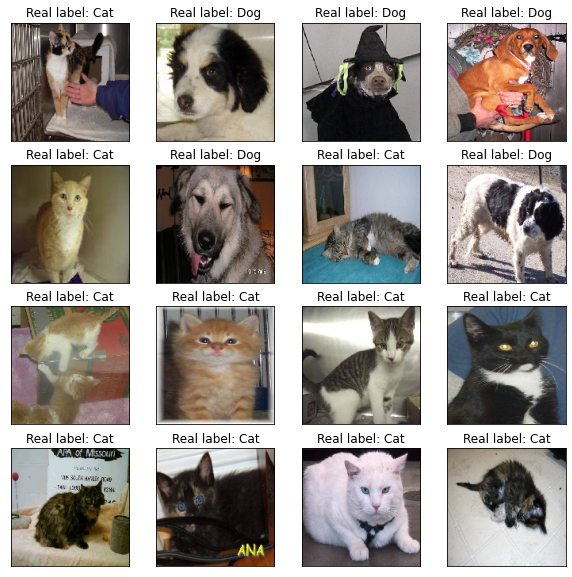

In [7]:
sample_training_images, sample_labels = next(train_gen)
show_catsdogs(sample_training_images, sample_labels)

# 3 Архитектура модели

In [8]:
PADDING = 'valid' # 'same'

convolutional_layer_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(150, 150, 3), activation='relu', padding=PADDING)
max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=2)

convolutional_layer_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding=PADDING)
max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=2)

convolutional_layer_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding=PADDING)
max_pool_3 = tf.keras.layers.MaxPool2D(pool_size=2)

convolutional_layer_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding=PADDING)
max_pool_4 = tf.keras.layers.MaxPool2D(pool_size=2)

flatten_layer = tf.keras.layers.Flatten()
dense_layer = tf.keras.layers.Dense(units=128, activation='relu', use_bias=False)

# Один выход т.к. вероятность получаем
dense_layer_out = tf.keras.layers.Dense(units=1, activation='sigmoid', use_bias=False)

layers = [convolutional_layer_1, max_pool_1,
          convolutional_layer_2, max_pool_2,
          convolutional_layer_3, max_pool_3,
          convolutional_layer_4, max_pool_4,
          flatten_layer, dense_layer, dense_layer_out
]

model = tf.keras.models.Sequential(layers=layers)


model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

model.summary()

2022-08-14 14:03:16.753575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 14:03:16.861956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 14:03:16.862763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 14:03:16.863787: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# 4 Обучение модели

In [9]:
# %load_ext tensorboard
# %tensorboard --logdir './tblogs'

In [10]:
EPOCHS = 30

history = model.fit(train_gen, 
                    epochs=EPOCHS, 
                    validation_data=val_gen, 
                    callbacks=[callback_tboard, callback_checkpoint])

2022-08-14 14:03:23.098896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-08-14 14:03:33.265546: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1/7 [===>..........................] - ETA: 1:50 - loss: 0.6944 - accuracy: 0.4670

2022-08-14 14:03:41.623385: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-14 14:03:41.623427: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


2/7 [=======>......................] - ETA: 3s - loss: 0.7355 - accuracy: 0.4890  

2022-08-14 14:03:42.340379: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-14 14:03:42.340980: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-08-14 14:03:42.476807: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 163 callback api events and 160 activity events. 
2022-08-14 14:03:42.485389: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-14 14:03:42.499185: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tblogs/2022-08-14_17-02-59/train/plugins/profile/2022_08_14_14_03_42

2022-08-14 14:03:42.504672: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tblogs/2022-08-14_17-02-59/train/plugins/profile/2022_08_14_14_03_42/188440a83a56.trace.json.gz
2022-08-14 14:03:42.527492: I tensorflow/core/profiler/rpc/client/save_profile

7/7 [==============================] - 67s 8s/step - loss: 0.7078 - accuracy: 0.4970 - val_loss: 0.6930 - val_accuracy: 0.5302


2022-08-14 14:04:30.677847: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/30
7/7 [==============================] - 29s 4s/step - loss: 0.6934 - accuracy: 0.5082 - val_loss: 0.6934 - val_accuracy: 0.5002
Epoch 3/30
7/7 [==============================] - 30s 4s/step - loss: 0.6940 - accuracy: 0.4920 - val_loss: 0.6950 - val_accuracy: 0.4998
Epoch 4/30
7/7 [==============================] - 29s 4s/step - loss: 0.6946 - accuracy: 0.4997 - val_loss: 0.6936 - val_accuracy: 0.4998
Epoch 5/30
7/7 [==============================] - 28s 4s/step - loss: 0.6930 - accuracy: 0.5002 - val_loss: 0.6923 - val_accuracy: 0.5927
Epoch 6/30
7/7 [==============================] - 28s 5s/step - loss: 0.6926 - accuracy: 0.4995 - val_loss: 0.6919 - val_accuracy: 0.5037
Epoch 7/30
7/7 [==============================] - 28s 5s/step - loss: 0.6930 - accuracy: 0.5070 - val_loss: 0.6923 - val_accuracy: 0.5002
Epoch 8/30
7/7 [==============================] - 29s 4s/step - loss: 0.6933 - accuracy: 0.5043 - val_loss: 0.6945 - val_accuracy: 0.4998
Epoch 9/30
7/7 [==================

In [11]:
import shutil
shutil.make_archive(base_name='./data', format='zip', base_dir='./data')
shutil.make_archive(base_name='./models', format='zip', base_dir='./models')
shutil.make_archive(base_name='./tblogs', format='zip', base_dir='./tblogs')

# Выгрузка логов (ссылка для скачивания)
from IPython.display import FileLink
FileLink(r'tblogs.zip')

# не работает из kaggel не получается получить credentional, можно загружать с рабочего компьютера
# tensorboard dev upload --logdir tglogs

/kaggle/working/tblogs.zip

# 5 Тестирование модели

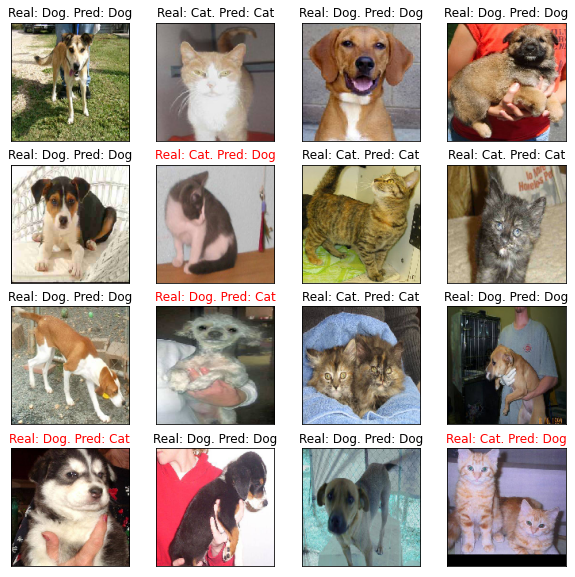

In [13]:
sample_test_images, sample_test_labels = next(test_gen)

predicted = (model.predict(sample_test_images) > 0.5).astype("int32").flatten()
show_catsdogs(sample_test_images,sample_test_labels, predicted)